In [0]:
import os
os.environ['DISABLE_COLAB_TF_IMPORT_HOOK'] = '1'

In [0]:
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET 
import random
from scipy import ndimage
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
import re 

In [2]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

import sys

sys.path.insert(1, '/content/drive/My Drive/ladd')

from data_utils.ImageDataAugmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
import tqdm

from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tqdm import tqdm


Using TensorFlow backend.


In [3]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32
   
TRAIN_AUGMENTATIONS = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=0.5)



train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #brightness_range=(0.9, 1.05),
    channel_shift_range=5.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/ladd/clean/clean_both/train/', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/ladd/clean/clean_both/val/', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,class_mode='binary')

Found 7216 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


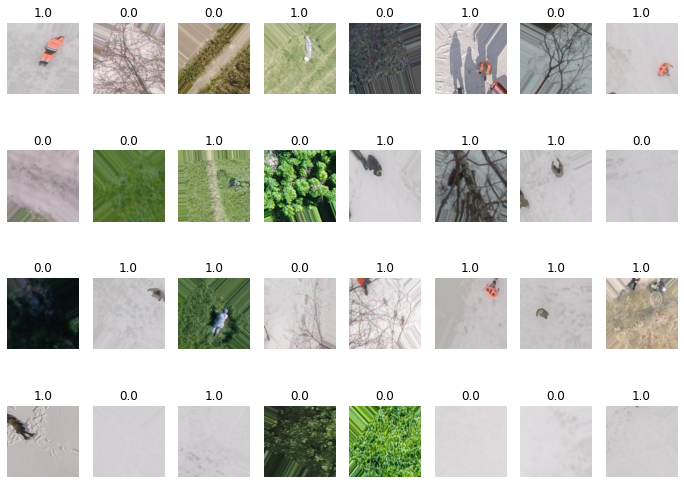

In [4]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.title(lbl)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

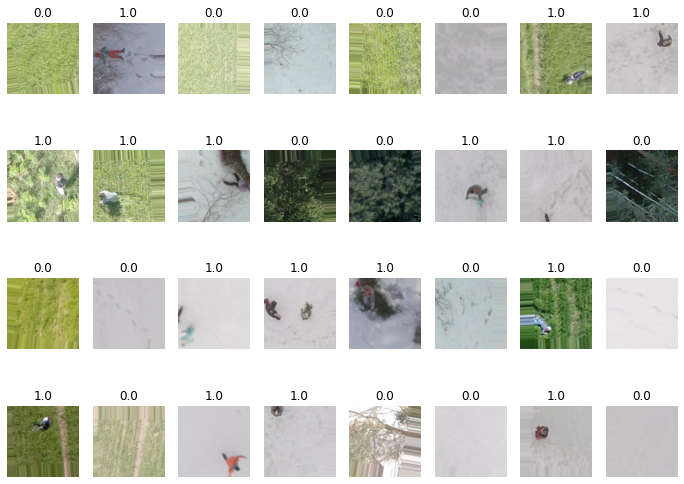

In [5]:
x_batch, y_batch = next(validation_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.title(lbl)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [6]:
restnet50 = ResNet50V2(include_top=False,pooling='max', weights='imagenet', input_shape=(HEIGHT,WIDTH,3))

94674944/94668760 [==============================] - 3s 0us/step


In [7]:


for layer in restnet50.layers:
    layer.trainable = False

restnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import keras.backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

Learning rate schedule: 0.0001 to 0.0001 to 1.43e-05


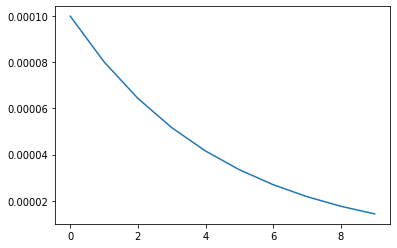

In [14]:
LR_START = 0.0001
LR_MAX = 0.0001
LR_MIN = 0.000001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [15]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import keras

model = restnet50.output
model = Dense(1000, activation='relu')(model)
model = Dropout(0.2)(model)
model = Dense(512, activation='relu')(model)
model = Dense(1, activation='sigmoid')(model)

model = Model(inputs=restnet50.input, outputs=model)

model.compile(loss=binary_focal_loss(),
              optimizer=optimizers.Adam(learning_rate=0.000005),
              metrics=['accuracy',f1, keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    mode='min',
    verbose=1)

checkpoint = ModelCheckpoint(
    'model_best_weights_2.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=5)




history = model.fit_generator(train_generator, 
                              steps_per_epoch=1000, 
                              epochs=10,
                              validation_data=validation_generator, 
                              validation_steps=500, 
                              verbose=1,
                              callbacks = [checkpoint,lr_callback])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
 182/1000 [====>.........................] - ETA: 2:03:35 - loss: 0.0983 - accuracy: 0.8729 - f1: 0.8625 - recall_1: 0.8131 - precision_1: 0.9242

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 188 could not be retrieved. It could be because a worker has died.
  UserWarning)


 999/1000 [============================>.] - ETA: 2s - loss: 0.0591 - accuracy: 0.8824 - f1: 0.8731 - recall_1: 0.8232 - precision_1: 0.9341

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


1000/1000 [==============================] - 3598s 4s/step - loss: 0.0592 - accuracy: 0.8823 - f1: 0.8728 - recall_1: 0.8232 - precision_1: 0.9337 - val_loss: 0.0169 - val_accuracy: 0.9322 - val_f1: 0.9252 - val_recall_1: 0.8717 - val_precision_1: 0.9918
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 8.020000000000001e-05.
1000/1000 [==============================] - 635s 635ms/step - loss: 0.0292 - accuracy: 0.9045 - f1: 0.8973 - recall_1: 0.8458 - precision_1: 0.9583 - val_loss: 0.0101 - val_accuracy: 0.9269 - val_f1: 0.9190 - val_recall_1: 0.8574 - val_precision_1: 0.9957
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 6.436000000000001e-05.
1000/1000 [==============================] - 640s 640ms/step - loss: 0.0247 - accuracy: 0.9126 - f1: 0.9065 - recall_1: 0.8553 - precision_1: 0.9662 - val_loss: 0.0227 - val_accuracy: 0.9253 - val_f1: 0.9159 - val_recall_1: 0.8528 - val_precision_1: 0.9973
Epoch 4/10

Epoch 00004: LearningRateSc

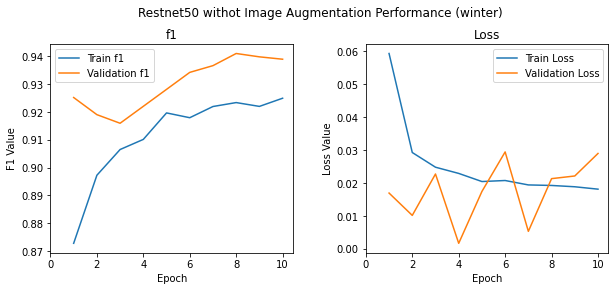

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Restnet50 withot Image Augmentation Performance (winter)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['f1'], label='Train f1')
ax1.plot(epoch_list, history.history['val_f1'], label='Validation f1')
ax1.set_xticks(np.arange(0, 12, 2))
ax1.set_ylabel('F1 Value')
ax1.set_xlabel('Epoch')
ax1.set_title('f1')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 12, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [62]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/ladd/clean/clean_both/test', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode=None,
    shuffle=False)

Found 1107 images belonging to 2 classes.


In [0]:
test_generator.reset()

In [65]:
pred=model.predict_generator(test_generator,verbose=1,steps=1107/BATCH_SIZE)

 8/34 [=====>........................] - ETA: 10:37

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/34 [======>.......................] - ETA: 10:51

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/34 [=======>......................] - ETA: 10:56

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/34 [===============>..............] - ETA: 6:56

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/34 [================>.............] - ETA: 6:34

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/34 [==================>...........] - ETA: 5:20

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/34 [====================>.........] - ETA: 4:37

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/34 [=====================>........] - ETA: 4:10

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/34 [==============================] - 967s 28s/step


In [0]:
y_p = []
for i in pred:
  if i > 0.5:
    y_p.append(1)
  else:
    y_p.append(0)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [78]:
test_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [79]:
print(confusion_matrix(test_generator.classes, y_p))

[[515   3]
 [ 33 556]]


In [0]:
tn, fp, fn, tp = confusion_matrix(test_generator.classes, y_p).ravel()

In [84]:
print(tn, fp, fn, tp)

515 3 33 556


In [0]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(test_generator, 1107 // 32+1)
#y_pred = np.argmax(Y_pred, axis=1)
#argmax doesn't work?

In [0]:
class_labels = list(test_generator.class_indices.keys()) 

In [0]:
from sklearn.metrics import classification_report
report = classification_report(test_generator.classes, y_p, target_names=class_labels)

In [82]:
print(report)

              precision    recall  f1-score   support

  Background       0.94      0.99      0.97       518
  Pedestrian       0.99      0.94      0.97       589

    accuracy                           0.97      1107
   macro avg       0.97      0.97      0.97      1107
weighted avg       0.97      0.97      0.97      1107



In [31]:
!pip install efficientnet

In [0]:
import efficientnet.keras as efn 

In [37]:
ef = efn.EfficientNetB0(weights='imagenet')


21831680/21826536 [==============================] - 1s 0us/step


In [0]:
for layer in ef.layers:
    layer.trainable = False

In [41]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import keras

model2 = ef.output
model2 = Dense(512, activation='relu')(model2)
model2 = Dense(1, activation='sigmoid')(model2)

model2 = Model(inputs=ef.input, outputs=model2)

model2.compile(loss=binary_focal_loss(),
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy',f1, keras.metrics.Recall(), keras.metrics.Precision()])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    mode='min',
    verbose=1)

checkpoint = ModelCheckpoint(
    'model_best_weights_ef.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=5)




history = model2.fit_generator(train_generator, 
                              steps_per_epoch=1000, 
                              epochs=10,
                              validation_data=validation_generator, 
                              validation_steps=500, 
                              verbose=1,
                              callbacks = [checkpoint])

Epoch 1/10
1000/1000 [==============================] - 634s 634ms/step - loss: 0.0634 - accuracy: 0.5542 - f1: 0.1755 - recall_3: 0.1110 - precision_3: 0.9752 - val_loss: 0.0523 - val_accuracy: 0.6508 - val_f1: 0.4589 - val_recall_3: 0.3102 - val_precision_3: 0.9747
Epoch 2/10
1000/1000 [==============================] - 605s 605ms/step - loss: 0.0449 - accuracy: 0.7439 - f1: 0.6612 - recall_3: 0.5042 - precision_3: 0.9693 - val_loss: 0.0768 - val_accuracy: 0.7013 - val_f1: 0.5745 - val_recall_3: 0.4265 - val_precision_3: 0.9465
Epoch 3/10
1000/1000 [==============================] - 602s 602ms/step - loss: 0.0393 - accuracy: 0.7882 - f1: 0.7399 - recall_3: 0.6027 - precision_3: 0.9582 - val_loss: 0.0609 - val_accuracy: 0.7232 - val_f1: 0.6200 - val_recall_3: 0.4726 - val_precision_3: 0.9476
Epoch 4/10
1000/1000 [==============================] - 602s 602ms/step - loss: 0.0368 - accuracy: 0.8086 - f1: 0.7696 - recall_3: 0.6436 - precision_3: 0.9597 - val_loss: 0.0761 - val_accuracy: 0